In [5]:
import gilda
import json
from glob import glob
import os

# map GLKB entity to biored

In [2]:
vocab = json.load(open('/nfs/turbo/umms-drjieliu/proj/prompt_re/kg_embeddings/data/node_index_mappings.json'))
in_path = '/nfs/turbo/umms-drjieliu/proj/prompt_re/KnowPrompt/dataset/biored2/*.txt'
out_path = '/nfs/turbo/umms-drjieliu/proj/prompt_re/biored2kg/biored_mapped'

for f in glob(in_path):
    content = []
    with open(f) as f:
        for l in f:
            content.append(eval(l))

    count = 0
    for dat in content:
        h_m = gilda.ground(dat.get('h').get('name'))
        if len(h_m)>0:
            mapped = ['_'.join(i) for i in h_m[0].get_groundings()]
            # mapped = [i for i in mapped if i in vocab.keys()]
        else:
            mapped = []
        dat['h']['mappings'] = mapped

        t_m = gilda.ground(dat.get('t').get('name'))
        if len(t_m)>0:
            mapped = ['_'.join(i) for i in t_m[0].get_groundings()]
            # mapped = [i for i in mapped if i in vocab.keys()]
        else:
            mapped = []
        dat['t']['mappings'] = mapped

        if len(dat['h']['mappings'])>0 and len(dat['t']['mappings'])>0:
            count += 1

    print('dataset:', f.name)
    print('dataset size:', len(content))
    print('mapped size:', count)
    
    # with open(os.path.join(out_path, os.path.split(f.name)[-1]), 'w') as o:
    #     o.writelines([str(l)+'\n' for l in content])

dataset: /nfs/turbo/umms-drjieliu/proj/prompt_re/KnowPrompt/dataset/biored2/val.txt
dataset size: 1958
mapped size: 1394
dataset: /nfs/turbo/umms-drjieliu/proj/prompt_re/KnowPrompt/dataset/biored2/train.txt
dataset size: 7435
mapped size: 5468
dataset: /nfs/turbo/umms-drjieliu/proj/prompt_re/KnowPrompt/dataset/biored2/test.txt
dataset size: 1904
mapped size: 1247


In [19]:
vocab = json.load(open('/nfs/turbo/umms-drjieliu/proj/prompt_re/kg_embeddings/data/node_index_mappings.json'))
in_path = '/nfs/turbo/umms-drjieliu/proj/prompt_re/KnowPrompt/dataset/biored2/*.txt'
out_path = '/nfs/turbo/umms-drjieliu/proj/prompt_re/biored2kg/biored_mapped'

for f in glob(in_path):
    content = []
    with open(f) as f:
        for l in f:
            content.append(eval(l))

    count = 0
    for dat in content:
        h_m = gilda.ground(dat.get('h').get('name'))
        if len(h_m)>0:
            mapped = ['_'.join(i) for i in h_m[0].get_groundings()]
            mapped = [i for i in mapped if i in vocab.keys()]
        else:
            mapped = []
        dat['h']['mappings'] = mapped

        t_m = gilda.ground(dat.get('t').get('name'))
        if len(t_m)>0:
            mapped = ['_'.join(i) for i in t_m[0].get_groundings()]
            mapped = [i for i in mapped if i in vocab.keys()]
        else:
            mapped = []
        dat['t']['mappings'] = mapped

        if len(dat['h']['mappings'])>0 and len(dat['t']['mappings'])>0:
            count += 1

    print('dataset:', f.name)
    print('dataset size:', len(content))
    print('mapped size:', count)
    
    with open(os.path.join(out_path, os.path.split(f.name)[-1]), 'w') as o:
        o.writelines([str(l)+'\n' for l in content])

dataset: /nfs/turbo/umms-drjieliu/proj/prompt_re/KnowPrompt/dataset/biored2/val.txt
dataset size: 1958
mapped size: 321
dataset: /nfs/turbo/umms-drjieliu/proj/prompt_re/KnowPrompt/dataset/biored2/train.txt
dataset size: 7435
mapped size: 1496
dataset: /nfs/turbo/umms-drjieliu/proj/prompt_re/KnowPrompt/dataset/biored2/test.txt
dataset size: 1904
mapped size: 319


# add GLKB types to biored

In [ ]:
biored2glkb_type = {'CellLine': 'Anatomy',
 'ChemicalEntity': 'Chemicals and Drugs',
 'DiseaseOrPhenotypicFeature': 'Diseases',
 'GeneOrGeneProduct': 'Genes and Gene Products',
 'OrganismTaxon': 'Organisms',
  }

get_type = lambda x: biored2glkb_type.get(x) if biored2glkb_type.get(x) else 'Others'

in_path = '/nfs/turbo/umms-drjieliu/proj/prompt_re/biored2kg/biored_mapped/*.txt'
out_path = '/nfs/turbo/umms-drjieliu/proj/prompt_re/biored2kg/biored_mapped_typed'

for f in glob(in_path):
    content = []
    with open(f) as f:
        for l in f:
            content.append(eval(l))

    for c in content:
        c['h']['type'] = get_type(c['h']['type'])
        c['t']['type'] = get_type(c['t']['type'])
    with open(os.path.join(out_path, os.path.split(f.name)[-1]), 'w') as o:
        o.writelines([str(l)+'\n' for l in content])

# add GLKB types to KG data

In [171]:
import requests
from collections import Counter, defaultdict
import torch
import numpy as np

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [26]:
all_nodes = json.load(open('/nfs/turbo/umms-drjieliu/proj/prompt_re/kg_embeddings/data/node_index_mappings.json'))

In [31]:
query = 'MATCH (v:Vocabulary) WHERE v.`Element ID` IN {} RETURN v.`Element ID`, LABELS(v)'
url = 'https://glkb.dcmb.med.umich.edu/api/1.0/_cypher_query'
all_keys = list(all_nodes.keys())
results = []
for ks in chunks(all_keys, 100):
    params = {'cypher': query.format(ks)}

    response = requests.get(url, verify=False, params=params)
    results += response.json()

/home/hyhao/miniconda3/envs/KG/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'glkb.dcmb.med.umich.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/hyhao/miniconda3/envs/KG/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'glkb.dcmb.med.umich.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/hyhao/miniconda3/envs/KG/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'glkb.dcmb.med.umich.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  w

In [35]:
# all labels in KG
label2ids = {}
for r in results:
    r[1].remove('Vocabulary')
    label2ids[r[0]] = r[1]
json.dump(label2ids, open('/nfs/turbo/umms-drjieliu/proj/prompt_re/kg_embeddings/data/node_labels.json', 'w'))

all_labels = []
for v in label2ids.values():
    all_labels += v
Counter(all_labels)

Counter({'Diseases': 1391,
         'Chemicals and Drugs': 2667,
         'Genes and Gene Products': 5402,
         'Anatomy': 49,
         'GO': 20,
         'Organisms': 66})

In [59]:
def multihot_encoder(labels, dtype=torch.float32):
    """ Convert list of label lists into a 2-D multihot Tensor """
    label_set = set()
    for label_list in labels:
        label_set = label_set.union(set(label_list))
    label_set = sorted(label_set)

    multihot_vectors = []
    for label_list in labels:
        multihot_vectors.append([1 if x in label_list else 0 for x in label_set])

    # To keep track of which columns are which, set dtype to None and...
    # import pandas as pd
    # if dtype is None:
    #     return pd.DataFrame(multihot_vectors, columns=label_set)
    return torch.Tensor(multihot_vectors).to(dtype)



In [177]:
type_dict = {'Anatomy': 0,
'Chemicals and Drugs': 1,
'Diseases': 2,
'Genes and Gene Products': 3,
'Organisms': 4,
'GO': 5
}

labs = json.load(open('/nfs/turbo/umms-drjieliu/proj/prompt_re/kg_embeddings/data/node_labels.json'))
idx = json.load(open('/nfs/turbo/umms-drjieliu/proj/prompt_re/kg_embeddings/data/node_index_mappings.json'))

idx2label = {}
for k, v in labs.items():
    idx2label[idx.get(k)] = [type_dict.get(i) for i in v]

node_labels = multihot_encoder(list(idx2label.values()))[np.argsort(np.array(list(idx2label.keys())))]
json.dump(type_dict, open('/nfs/turbo/umms-drjieliu/proj/prompt_re/kg_embeddings/data/node_label_mappings.json', 'w'))

label2idx = defaultdict(list)
for k, vs in labs.items():
    for v in vs:
        label2idx[v].append(idx.get(k))
json.dump(label2idx, open('/nfs/turbo/umms-drjieliu/proj/prompt_re/kg_embeddings/data/node_label_to_index.json', 'w'))

In [87]:
import dgl

FILE = '/nfs/turbo/umms-drjieliu/proj/prompt_re/kg_embeddings/data/semantic_graph_10part.bin'
data, _ = dgl.load_graphs(FILE)
G = data[-1]
G.ndata['labels'] = node_labels
dgl.save_graphs('/nfs/turbo/umms-drjieliu/proj/prompt_re/kg_embeddings/data/semantic_graph_nodetypes.bin', G)

In [89]:
g = dgl.to_homogeneous(G, ndata=['emb', 'labels'])

# visualize node embeddings

In [164]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import dgl

INFO: [2023-10-05 13:03:03] numexpr.utils - Note: NumExpr detected 28 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: [2023-10-05 13:03:03] numexpr.utils - NumExpr defaulting to 8 threads.


In [144]:
data, _ = dgl.load_graphs('/nfs/turbo/umms-drjieliu/proj/prompt_re/kg_embeddings/data/semantic_graph_nodetypes.bin')
G = data[-1]
g = dgl.to_homogeneous(G, ndata=['emb', 'labels'])

In [135]:
embs = torch.load('/nfs/turbo/umms-drjieliu/proj/prompt_re/kg_embeddings/outputs/term_embeddings_lp+nc.pk')
embs2 = PCA().fit_transform(embs.detach().numpy())

In [155]:
labs = json.load(open('/nfs/turbo/umms-drjieliu/proj/prompt_re/kg_embeddings/data/node_labels.json'))
idx = json.load(open('/nfs/turbo/umms-drjieliu/proj/prompt_re/kg_embeddings/data/node_index_mappings.json'))
idx2label = {}
for k, v in labs.items():
    idx2label[idx.get(k)] = '|'.join(list(set(v)))

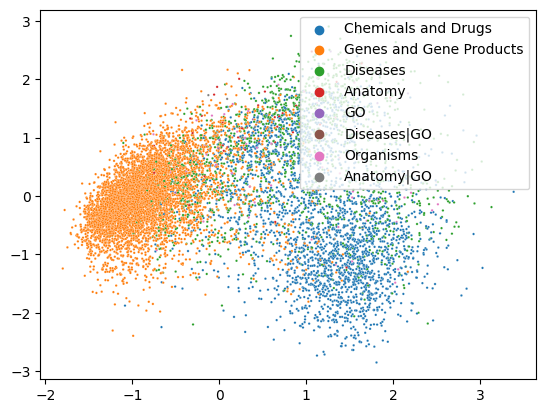

In [168]:
labels = np.array(list(idx2label.values()))[np.argsort(list(idx2label.keys()))]

sns.scatterplot(x=embs2[:,0], y=embs2[:,1], hue=labels, s=3)
plt.show()

# lightning

In [3]:
import sys
sys.path.append('/nfs/turbo/umms-drjieliu/proj/prompt_re/kg_embeddings')
from hgt_lightning_lp import LitHGT

OSError: libc10_cuda.so: cannot open shared object file: No such file or directory

In [ ]:
model = LitHGT(FILE='/nfs/turbo/umms-drjieliu/proj/prompt_re/kg_embeddings/data/semantic_graph_nodetypes.bin')